In [1]:
from qiskit import * 
from qiskit.tools.visualization import plot_histogram 
from qiskit.extensions import UnitaryGate 
import numpy as np 

In [2]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.17.3', 'qiskit-aer': '0.8.2', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.13.1', 'qiskit-aqua': '0.9.1', 'qiskit': '0.26.0', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [10]:
class KQPE():
    '''This is a class which is used to generate the Kitaev QPE algorithm. 
    ATTRIBUTES : precision -> int or float 
                the precision upto which the phase needs to be estimated 
                NOTE : if Type is int, precision is estimated as 2^(-precision)
                
                unitary -> np.ndarray or QuantumCircuit or UnitaryGate 
                the unitary matrix for which we want to find the phase, given 
                its eigenvalue 
                '''
    def __init__(self, unitary,precision = 10):
        
        # handle precision 
        if not isinstance(precision,int) and not isinstance(precision,float):
            raise TypeError("Precision needs to be an integer or float")
        elif precision <=0:
            raise ValueError("Precision needs to be >=0")
        
        if isinstance(precision,int):
            self.precision = 1/(2**precision)
        else:
            self.precision = 1/precision 
            
        #handle unitary 
        if unitary is None:
            raise Exception("Unitary needs to be specified for the Kitaev QPE algorithm") 
        elif not isinstance(unitary,np.ndarray) and not isinstance(unitary,QuantumCircuit) and not isinstance(unitary,UnitaryGate):
            raise TypeError("A numpy array, QuantumCircuit or UnitaryGate needs to be passed as the unitary matrix")

        self.unitary = unitary 
        # get the number of qubits in the unitary 
        if isinstance(unitary,np.ndarray):
            self.qubits = int(np.log2(unitary.shape[0]))
        else:
            self.qubits = int(unitary.num_qubits)
            
    def get_phase(self,QC,ancilla,clbits,backend, show = False):
        '''This function is used to determine the 
        final measured phase from the circuit 
        with the specified precision.
        
        PARAMETERS : ancilla : the qubits which have the kitaevs's circuit
                     clbits : the bits to measure into
                     show : to display the measured circuit
        RETURNS : phase of the circuit - float
        '''
        # handle circuit
        if len(QC.clbits) < 2:
            raise Exception("Atleast 2 classical bits needed for measurement")
        elif len(QC.qubits) < 3:
            raise Exception("Quantum Circuit needs to have atleast 3 qubits")
            
        # handle bits
        elif len(ancilla)!=2 or ancilla is None:
            raise Exception("Exactly two ancilla bits need to be specified")
        elif len(clbits)!=2 or clbits is None:
            raise Exception("Exactly two classical bits need to be specified for measurement")
        
        
        #handle backend 
        if backend is None:
            raise Exception("Backend needs to be provided to execute circuit")
        
        # find number of shots -> atleast O(1/precision shots)
        
        # correct this ...
        shots = 10*int(1/self.precision)
        if show == True:
            print("Shots :",shots)
        
        # measure into the given bits 
        QC.measure([ancilla[0],ancilla[1]],[clbits[0],clbits[1]])
        
        if show == True:
            display(QC.draw('mpl'))
            
        # execute the circuit 
        result = execute(QC,backend = backend,shots = shots,optimization_level = 3).result()
        counts = result.get_counts()
        if show:
            print("Measurement results :",counts)
        if show:
            display(plot_histogram(counts))
        
        # now get the results
        C0,C1,S0,S1 = 0,0,0,0
        first = clbits[0]
        second = clbits[1]
        for i,j in zip(list(counts.keys()),list(counts.values())):
            # get bits
            l = len(i)
            one = i[l-first-1]
            two = i[l-second-1]
            
            ## First qubit 0 - C (0,theta)
            if one == '0':
                C0+=j               
            ## First qubit 1 - C (1,theta)
            else:
                C1+=j
            ## Second qubit 0 - S (0,theta)
            if two == '0':
                S0+=j
            ## Second qubit 1 - S (1,theta)
            else:
                S1+=j 
        
        # normalize
        C0, C1, S0, S1 = C0/shots, C1/shots, S0/shots, S1/shots
#         print("C0:",C0,"C1:",C1,"S0:",S0,"S1:",S1)
        
        # determine theta_0
        tan_1 = np.arctan2([(1-2*S0)], [(2*C0-1)])[0]
        theta_0 = (1/(2*np.pi))*tan_1
        
        #determine theta_1
        tan_2 = np.arctan2([(2*S1 - 1)], [(1-2*C1)])[0]
        theta_1 = (1/(2*np.pi))*tan_2
        
        return (np.average([theta_0,theta_1]))
        
    
    def get_circuit(self,show = False,save_circ = False, circ_name = "KQPE_circ.JPG"):
        '''Returns a KITAEV phase estimation circuit 
           with the unitary provided'''
        qc = QuantumCircuit(2 + self.qubits,name = 'KQPE') 
        qubits = [i for i in range(2,2+self.qubits)]
        
        # make the unitary 
        if isinstance(self.unitary,np.ndarray):
            U = UnitaryGate(data = self.unitary)
            C_U = U.control(num_ctrl_qubits = 1,label='CU',ctrl_state = '1')
        else:
            C_U = self.unitary.control(num_ctrl_qubits = 1,label = 'CU',ctrl_state = '1')
        
        
        # qubit 0 is for the H estimation 
        qc.h(0)
        qc = qc.compose(C_U,qubits = [0] + qubits)
        qc.h(0)
        qc.barrier()    
        
        # qubit 1 is for the H + S estimation
        qc.h(1)
        qc.s(1)
        qc = qc.compose(C_U,qubits = [1] + qubits)
        qc.h(1)
        
        qc.barrier()
        if show == True:
            if save_circ:
                display(qc.draw('mpl',filename = circ_name))
            else:
                display(qc.draw('mpl'))

        return qc 
    

### Tesing Kitaev Circuit for 1-qubit
- Note that the get_phase method is called over a KQPE object and the parameters that are passed are the **qubit number of the eigenvector and the quantum circuit** containing it.
- Note that the person using KQPE needs to have atleast 2 classical bits to actually execute this circuit measurements.
- Testing the circuit for displaced argument also works 

In [15]:
U= np.array([[1,0],
              [0,np.exp(2*np.pi*1j*(1/3))]])


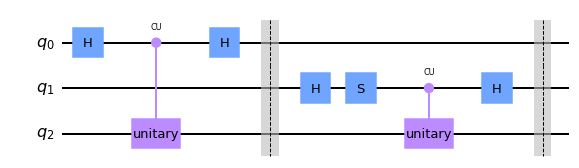

In [24]:
kqpe = KQPE(unitary=U,precision = 15)
kq_circ = kqpe.get_circuit(show = True,save_circ = True, circ_name= "KQPE_circ_1qubit.JPG")

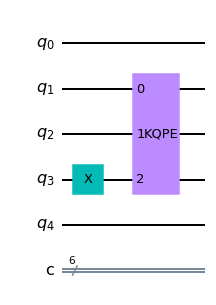

In [25]:
q = QuantumCircuit(5,6)
q.x(3)
q.append(kq_circ,qargs = [1,2,3])
q.draw('mpl')

Shots : 327680


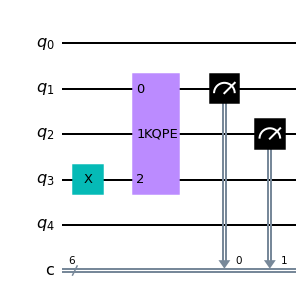

Measurement results : {'000010': 76361, '000011': 229128, '000001': 16650, '000000': 5541}


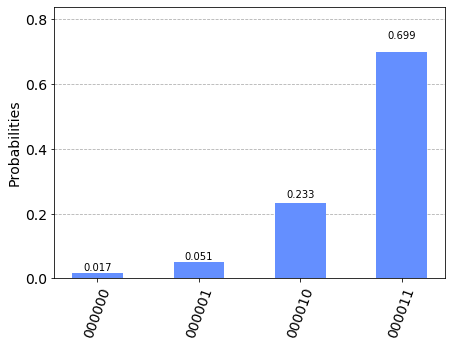

In [26]:
phase = kqpe.get_phase(backend = Aer.get_backend('qasm_simulator'),QC=q,ancilla=[1,2],clbits=[0,1],show = True)

In [27]:
print("Phase of the unitary is :",phase)

Phase of the unitary is : 0.33346549785729346


### Testing Kitaev for 2-qubits
- Making a Controlled phase gate with phase as 1/7
- The eigenvector is $ |11\rangle$

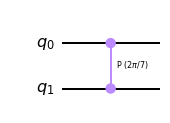

In [30]:
q = QuantumCircuit(2, name = 'Unitary')
q.cp(2*np.pi*(1/7),0,1)
q.draw('mpl')

In [31]:
unitary = q 

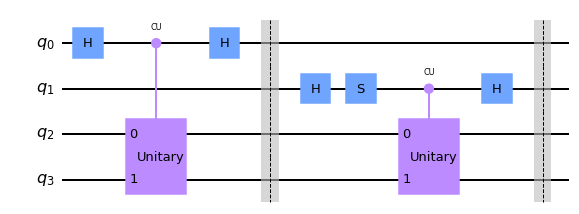

In [37]:
kqpe = KQPE(unitary,precision=12)
kq_circ = kqpe.get_circuit(show = True)

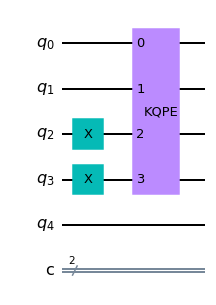

In [38]:
q = QuantumCircuit(5,2)
q.x([2,3])
q.append(kq_circ, qargs = [0,1,2,3])
q.draw('mpl')

In [39]:
sim = Aer.get_backend('qasm_simulator')

Shots : 40960


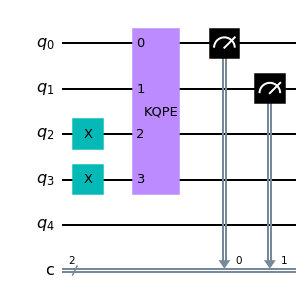

Measurement results : {'10': 29626, '00': 3495, '11': 6977, '01': 862}


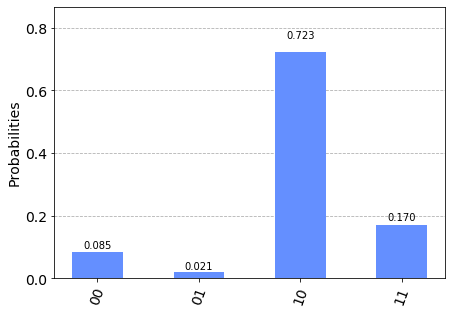

In [40]:
phase = kqpe.get_phase(backend=sim,QC=q,ancilla=[0,1],clbits=[0,1],show = True)

In [41]:
print("Phase returned is :",phase)

Phase returned is : 0.14417306622251747


- This is actually pretty close 
- Let us plot a graph with the returned phase

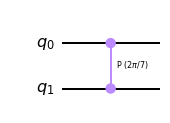

In [42]:
q = QuantumCircuit(2, name = 'Phase Unitary')
q.cp(2*np.pi*(1/7),0,1)
display(q.draw('mpl'))
unitary = q 


In [43]:
precision = [i for i in range(8,18)]
precision

[8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

In [44]:
estimates, errors = [], [] 
for prec in precision:
    kqpe = KQPE(unitary,precision=prec)
    print("Circuit for precision :",prec)    
    kq_circ = kqpe.get_circuit(show = False)
    
    # making circuit
    q = QuantumCircuit(5,2)
    q.x([2,3])
    q.append(kq_circ, qargs = [0,1,2,3])
    
    #getting the phase 
    phase = kqpe.get_phase(backend = sim,QC=q,ancilla=[0,1],clbits=[0,1],show = False)
    estimates.append(phase)
    errors.append(abs(1/7-phase))


Circuit for precision : 8
Circuit for precision : 9
Circuit for precision : 10
Circuit for precision : 11
Circuit for precision : 12
Circuit for precision : 13
Circuit for precision : 14
Circuit for precision : 15
Circuit for precision : 16
Circuit for precision : 17


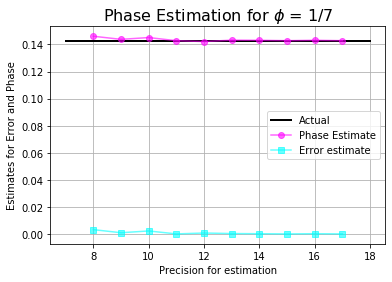

In [49]:
import matplotlib.pyplot as plt 
plt.title("Phase Estimation for $ \phi $ = 1/7",fontsize = 16)
plt.xlabel("Precision for estimation")
plt.ylabel("Estimates for Error and Phase") 
plt.plot([7,18],[1/7,1/7],color= 'black',label = 'Actual', linewidth = 2)
plt.plot(precision, estimates, marker = 'o', color = 'magenta',alpha = 0.6,label = 'Phase Estimate')
plt.plot(precision, errors, marker = 's', color = 'cyan',alpha = 0.6, label = "Error estimate")
plt.grid()
plt.legend()
plt.savefig("Kitaev Multiqubit Estimation.JPG",dpi = 200)